In [1]:
# Import List

import numpy as np # imports the numpy module which has functions related to manupulating arrays and implementing mathematical functions
import cv2 # imports opencv library for python. Image and video processing functions are available.
import glob # imports file handling library
import matplotlib.image as mpimg # imports library for plotting and displaying mathematical functions
import matplotlib.pyplot as plt # imports library for plotting and displaying mathematical functions
from mpl_toolkits.mplot3d import Axes3D # imports library for plotting 3D plots/graphs
from sklearn.preprocessing import StandardScaler # imports Machine learning library. Specifically normalizing function.
from sklearn.model_selection import train_test_split # imports machine learning library. Specifically data splitting function.
from sklearn.svm import LinearSVC # imports machine learning library. Specifically state vector machine model.
from sklearn import svm # Imports SVM module
from skimage.feature import hog # imports machine learning library. Specifically hog function.
from scipy.ndimage.measurements import label # Labels nonzero values in arrays

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Directive for ipython to show plots in notebook
%matplotlib inline 

In [2]:
# Image Color Histograms. The function takes an image, number of bins and range of bins as inputs.
# The image is a 3 channel input i.e. a 3 dimensional array. The values of the elements in each channel
# are between 0 - 255 and represent the intensity of that 'color' channel. The 'number of bins' are the 
# buckets/bins/containers/divisions for segmenting the channel elements. The value can vary from 1-255. 
# The bins range defining the max value of the element going into the bin????????? 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    ch1hist = np.histogram(img[:,:,0],nbins, bins_range)
    ch2hist = np.histogram(img[:,:,1],nbins, bins_range)
    ch3hist = np.histogram(img[:,:,2],nbins, bins_range)
    hist_features = np.concatenate((ch1hist[0], ch2hist[0], ch3hist[0]))
    return hist_features

# HOG refers to histogram of gradients not Ground Hog. The functions creates an histogram of the gradients with
# number of bins defined by 'orient', the number of pixels per cells to be used for gradient, the number of cells 
# per block defining the normalizin block size, vis being the boolean variable which is used to turn visualization 
# on or off and feature vector being the second boolean????????? This function takes in a single channel image as 
# an input.
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Spatial Binning. The function takes an image and size tuple as inputs and resizes the image to the size defined
# by the tuple. The resized image is then unraveled into a linear vector or 1D vector. The resizing bins the pixels
# spatially. HOW DOES THE RESIZE FUNCTION WORK?????
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Convert image to color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Feature extraction. The description mentioned here can be used for other extraction features functions as well.
# The function takes an image as an input and spits out features which will be used for machine learning.'Color' 
# histogram, spatial binning and hog functions are called to extract features which will be aggregated together and
# used to train a machine learning model.
# Color space: Different color spaces can be used to extract different features. Color information about intensity, 
# saturation, illumination etc can be extracted from different color spaces.
# hog channel determines the channel on which gradient of histogram is calculated.
# Rest of the inputs should be quite apparent.
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB': # Checks and converts to the specified color space
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            # 3072
            file_features.append(spatial_features) 
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features
    

# Normalizer: The function takes in the feature list and scales and normalizes it to prevent dominance of a certain
# feature on the training. The features are also centered for zero mean.
def normscale(feature_list):
    X = np.vstack(feature_list).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    return (scaled_X,X_scaler)

# State Vector Machine Classifier
def svmclass(normscale,labels):
    parameters = {'kernel': ('linear','rbf'), 'C': [1,2]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(normscale, labels)
    return clf


# Collection all vehicle and non-vehicle images together: The function accumulates the filenames of the image data.
def imgpathaccu(foldername):
    imagepathlist = []
    for folder in glob.glob(foldername+'/*'):
        for image in glob.glob(folder+'/*'):
                imagepathlist.append(image)
    return imagepathlist


# Slide window function creates a list of coordinate points where the windows will be 'drawn' on the image to collect 
# image data for detecting an tracking vehicles.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes. This should be obvious. 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HSV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [3]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler ,orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxlist = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size,spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxlist.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return (draw_img,boxlist)

In [4]:
def add_heat(heatmap, bbox_list):
    if len(bbox_list)>0:
        for box in bbox_list:
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    else:
        pass
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [5]:
cars = imgpathaccu('vehicles')
noncars = imgpathaccu('non-vehicles')

vehicles/GTI_Far/image0000.png
(64, 64, 3)
1764


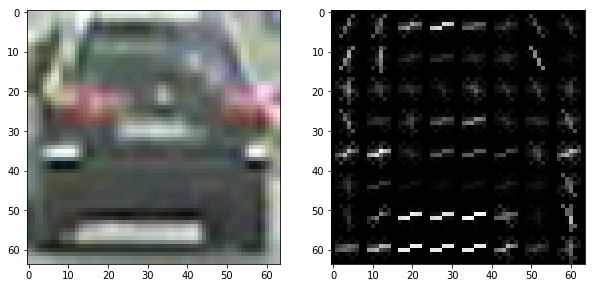

In [54]:
# Investigating Histogram of Gradient Features and Color Spaces
print(cars[0])
img = mpimg.imread(cars[780])
imgg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

out_img_test = get_hog_features(imgg, 9, 8, 2, vis=True, feature_vec=True)

f, splot = plt.subplots(1,2,figsize=(10,10))
splot[0].imshow(img)
print(img.shape)
splot[1].imshow(out_img_test[1],'gray')
#splot[2].imshow(out_img_test[1],'gray')
#splot[2].imshow(out_img_test[1],'gray')
print(len(out_img_test[0]))

# car_features = extract_features(cars,'HSV')
noncar_features = extract_features(noncars,'HSV')
scaled_X = normscale([car_features,noncar_features])

In [8]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [9]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X[0], y, test_size=0.3, random_state=rand_state)

In [10]:
svc = LinearSVC()
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [11]:
#print('Test Accuracy of SVC = ', svc.score(X_test,y_test))
print('Test Accuracy of SVC = ', svc.score(X_test,y_test))

Test Accuracy of SVC =  0.988551051051


2


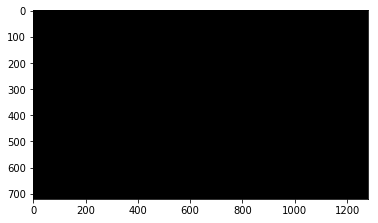

In [75]:
img = mpimg.imread('test2.jpg')
scale = 1
ystart = 400
ystop = 680

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = 32
hist_bins = 32

out_img = find_cars(img, ystart, ystop, scale, svc, scaled_X[1],orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(len(out_img))

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,out_img[1])
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
#plt.imshow(img)
plt.imshow(heatmap,cmap = "gray")
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
#plt.imshow(draw_img)



In [76]:
# Function to define multiple find car boxes
def vdtf(img):
    # Defining multiple scales
    scale = [1, 1.5, 2, 2.5, 3]
    ystart = 400
    ystop = 680 
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = 32
    hist_bins = 32
    windows= []
    for x in scale:
        if x<=2:
            ystart = 400
            ystop = 550
        else:
            ystart = 400
            ystop = 680
        out_img = find_cars(img, ystart, ystop, x, svc, scaled_X[1],orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        windows = windows + out_img[1]

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #return draw_img
    return heatmap

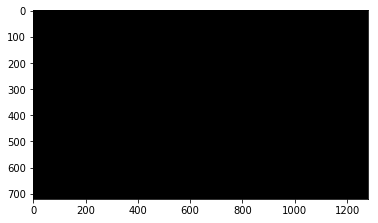

In [77]:
plt.imshow(vdtf(img),cmap="gray")

In [78]:
vid_output = 'project_video_short_1.mp4'
clip1 = VideoFileClip("project_video.mp4")
vid_clip = clip1.subclip(5,35) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_short_1.mp4
[MoviePy] Writing video project_video_short_1.mp4


100%|█████████▉| 750/751 [00:12<00:00, 56.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_short_1.mp4 

CPU times: user 968 ms, sys: 919 ms, total: 1.89 s
Wall time: 13.1 s


In [ ]:

vid_output1 = 'Vehicle_Detection_Tracking_100.mp4'
clip2 = VideoFileClip("project_video.mp4")
vid_clip = clip2.fl_image(vdtf) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output1, audio=False)

[MoviePy] >>>> Building video Vehicle_Detection_Tracking_100.mp4
[MoviePy] Writing video Vehicle_Detection_Tracking_100.mp4


  4%|▍         | 51/1261 [00:38<14:07,  1.43it/s]